In [1]:
from src.dataset import FinancialDataset, DataHandler
from src.trainer_new import PortfolioTrainer
from src.markowitz import MaxSharpe
from src.models import NN_Sharpe
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
%load_ext autoreload
%autoreload 2

# Class FinancialDataset

In [6]:
financial_dataset = FinancialDataset(synthetic=True, n_simul=10)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


In [7]:
financial_dataset.dataset

tensor([[[-0.0077,  0.0366],
         [ 0.0051,  0.0158],
         [ 0.0205, -0.0050],
         ...,
         [-0.0007,  0.0152],
         [ 0.0119,  0.0175],
         [-0.0196,  0.0006]]])

In [8]:
financial_dataset.dataset_synthetic

tensor([[[-0.0098, -0.0077],
         [-0.0315, -0.0219],
         [-0.0176, -0.0072],
         ...,
         [-0.0368, -0.0159],
         [-0.0175, -0.0056],
         [ 0.0334,  0.0146]],

        [[-0.0252,  0.0103],
         [ 0.0092, -0.0174],
         [ 0.0055, -0.0013],
         ...,
         [-0.0258, -0.0100],
         [ 0.0507,  0.0252],
         [ 0.0060,  0.0212]],

        [[ 0.0077,  0.0011],
         [ 0.0124,  0.0095],
         [ 0.0399,  0.0122],
         ...,
         [-0.0055,  0.0091],
         [ 0.0034,  0.0090],
         [-0.0303, -0.0367]],

        ...,

        [[ 0.0444,  0.0175],
         [-0.0096, -0.0252],
         [-0.0298, -0.0021],
         ...,
         [ 0.0315, -0.0031],
         [ 0.0200,  0.0162],
         [ 0.0066,  0.0174]],

        [[ 0.0218,  0.0183],
         [ 0.0098, -0.0258],
         [ 0.0222,  0.0084],
         ...,
         [-0.0176, -0.0359],
         [-0.0097,  0.0082],
         [-0.0099, -0.0083]],

        [[ 0.0316, -0.0039],
       

10 simulations gaussiennes pour les données synthétiques

torch.Size([10, 3791, 2])


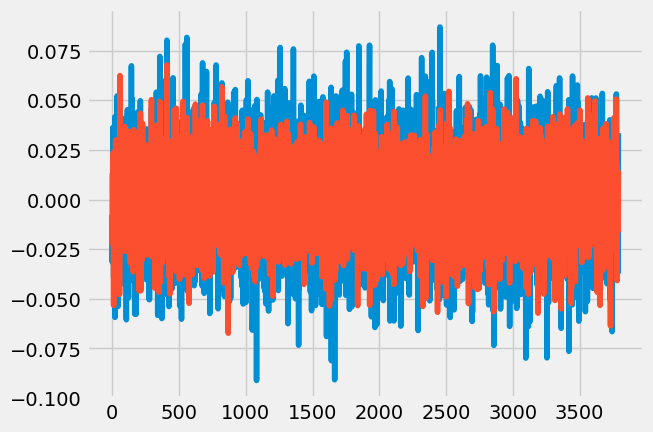

In [9]:
print(financial_dataset.dataset_synthetic.shape)
plt.plot(financial_dataset.dataset_synthetic[0, :, :])

<Axes: xlabel='Date'>

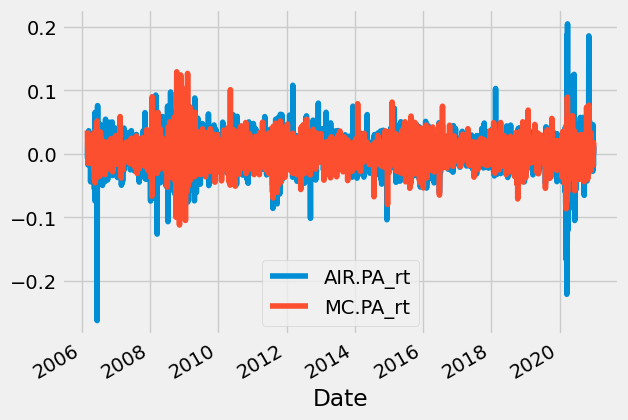

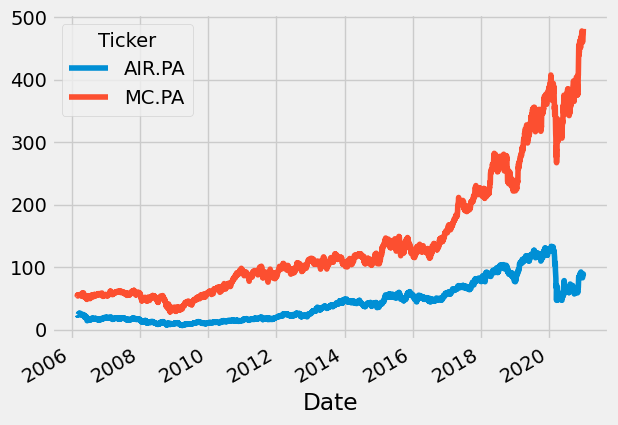

In [10]:
financial_dataset._raw_data['returns'].plot()
financial_dataset._raw_data['prices'].plot()

# dictionnaire qui contient 'prices' et 'returns

# Class DataHandler

In [11]:
data_handler = DataHandler(
    dataset=financial_dataset,
    initial_train_years=4,
    retrain_years=2,
    rolling_window=50,
    batch_size=1,
    overlap=True,
    shuffle=False,
    on_synthetic=True
)

In [12]:
for i in range(len(data_handler.periods_train)):
    print(f"TRAIN : {data_handler.periods_train[i]}; TEST : {data_handler.periods_invest[i]}")

TRAIN : (51, 1059); TEST : (1059, 1563)
TRAIN : (1059, 1563); TEST : (1563, 2067)
TRAIN : (1563, 2067); TEST : (2067, 2571)
TRAIN : (2067, 2571); TEST : (2571, 3075)
TRAIN : (2571, 3075); TEST : (3075, 3579)


### Méthode _compute_data

In [13]:
data_handler._compute_data(start=0,
                           end=100,
                           training=True,
                           )

"""
return : 
    rolling_window de la data basé sur l'overlap/training
    si training : retourne également le Y associé
"""

"\nreturn : \n    rolling_window de la data basé sur l'overlap/training\n    si training : retourne également le Y associé\n"

In [14]:
rolling_data = data_handler._compute_data(start=200,
                           end=300,
                           training=True)


In [15]:
dataloader, xtest, dates = data_handler.load_period(0)

Training period from 51 to 1059
Investment period from 1059 to 1563


In [16]:
len(xtest)

for sim in range(data_handler.n_simul):
    print(sim*(dates[3]-dates[2]), (sim+1)*(dates[3]-dates[2]))

0 504
504 1008
1008 1512
1512 2016
2016 2520
2520 3024
3024 3528
3528 4032
4032 4536
4536 5040


# Class PortfolioTrainer

In [7]:
financial_dataset = FinancialDataset(tickers=["XOM", "TLT", "GLD"], synthetic=True, n_simul=200000, n_synthetic=700)

data_handler = DataHandler(
    dataset=financial_dataset,
    initial_train_years=1,
    retrain_years=1,
    rolling_window=100,
    batch_size=5,
    overlap=False,
    shuffle=True,
    on_synthetic=True
)

trainer = PortfolioTrainer(
    model=NN_Sharpe(input_size=data_handler.n_assets,
                    hidden_size=10,
                    num_layers=3,
                    
                    output_size=data_handler.n_assets,
                    temperature=1),
    
    data_handler=data_handler,
    device='cpu',
    epochs=2,
    lr=0.001,
    weight_decay=0,
    permute_assets=False
)

trainer.train(compute_marko_weights=['sharpe_torch' , 'marko_torch'])
trainer.plot_weights(type_w='model', th_weights='sharpe')
trainer.plot_weights(type_w='sharpe', th_weights='sharpe')
trainer.plot_weights(type_w='marko', th_weights='marko')

Failed to get ticker 'GLD' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'TLT' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'XOM' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  3 of 3 completed

3 Failed downloads:
['GLD', 'TLT', 'XOM']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
/home/onyxia/work/DL-Portfolio-CMAP/src/dataset.py:123: RuntimeWarning: Mean of empty slice.
  self.mean = returns.mean(axis=0)
/opt/conda/lib/python3.12/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/conda/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:562: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/onyxia/work/DL-Portfolio-CMAP/src/dataset.py:124: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.cov = np.cov(returns, rowvar=False)
/opt/conda/lib/

KeyboardInterrupt: 

In [5]:
mean = np.array([0.00037681, 0.00031588, 0.00016635])
cov = np.array([[ 1.35957835e-04,  1.49690958e-05,  2.02862672e-05],
       [ 1.49690958e-05,  8.39153183e-05, -5.52688327e-05],
       [ 2.02862672e-05, -5.52688327e-05,  2.79139612e-04]])

financial_dataset = FinancialDataset(tickers=["XOM", "TLT", "GLD"], synthetic=True, n_simul=200000, n_synthetic=700, mean=mean, cov=cov/1000)

data_handler = DataHandler(
    dataset=financial_dataset,
    initial_train_years=1,
    retrain_years=1,
    rolling_window=100,
    batch_size=5,
    overlap=False,
    shuffle=True,
    on_synthetic=True
)

trainer = PortfolioTrainer(
    model=NN_Sharpe(input_size=data_handler.n_assets,
                    hidden_size=10,
                    num_layers=3,
                    
                    output_size=data_handler.n_assets,
                    temperature=1),
    
    data_handler=data_handler,
    device='cpu',
    epochs=2,
    lr=0.001,
    weight_decay=0,
    permute_assets=False
)

trainer.train(compute_marko_weights=['sharpe_torch' , 'marko_torch'])
trainer.plot_weights(type_w='model', th_weights='sharpe')
trainer.plot_weights(type_w='sharpe', th_weights='sharpe')
trainer.plot_weights(type_w='marko', th_weights='marko')


Failed to get ticker 'GLD' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'XOM' reason: Expecting value: line 1 column 1 (char 0)
[                       0%                       ]Failed to get ticker 'TLT' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  3 of 3 completed

3 Failed downloads:
['GLD', 'XOM', 'TLT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
/home/onyxia/work/DL-Portfolio-CMAP/src/markowitz.py:98: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  risk    = torch.sqrt(weights.T@cov_matrix@weights)


Training period from 101 to 353
Investment period from 353 to 605


KeyboardInterrupt: 